In [1]:
import numpy as np
from numpy import asarray
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage
from skimage.segmentation import clear_border
from skimage import data, exposure, img_as_float
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import label,regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import blend_modes
import plotly.graph_objects as go



c:\Users\rodhe\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(480, 640)


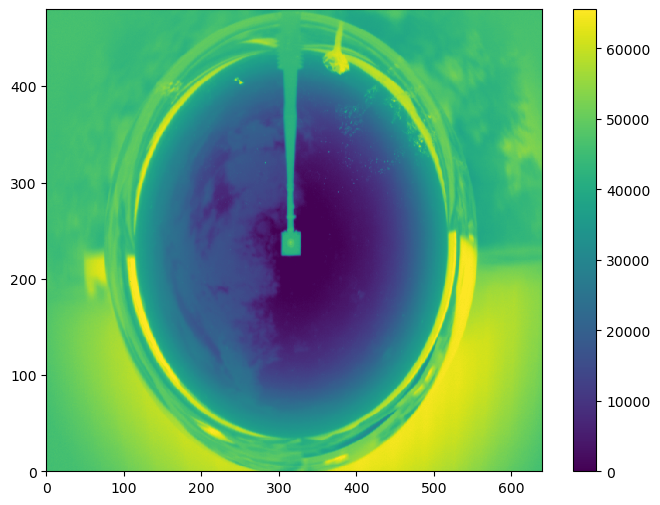

In [2]:
# filepath = '20230807_normal/20230807152030.png'
filepath = '20230807_normal/20230807163300.png'
img = Image.open(filepath)
img = asarray(img)
print(img.shape)
plt.figure(figsize=(8,6))
#÷plt.pcolormesh(img, cmap='Greys_r')
plt.pcolormesh(img)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


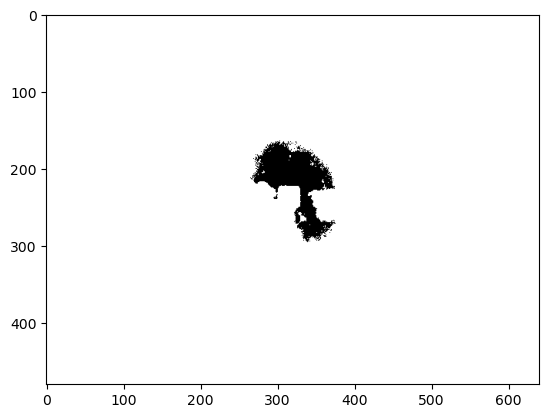

In [3]:



# Import background image
background_img_raw = Image.open('20230807_normal/20230807163300.png')  # RGBA image
background_img = np.array(background_img_raw)  # Inputs to blend_modes need to be numpy arrays.
background_img_float = background_img.astype(float)  # Inputs to blend_modes need to be floats.
background_img_float = np.stack((background_img_float, background_img_float, background_img_float, np.ones_like(background_img_float)), axis=-1)

# Import foreground image
foreground_img_raw = Image.open('20230807_normal/20230807163300.png')  # RGBA image
foreground_img = np.array(foreground_img_raw)  # Inputs to blend_modes need to be numpy arrays.
foreground_img_float = foreground_img.astype(float)  # Inputs to blend_modes need to be floats.
foreground_img_float = np.stack((foreground_img_float, foreground_img_float, foreground_img_float, 1*np.ones_like(foreground_img_float)), axis=-1)


# Blend images
opacity = 0.7  # The opacity of the foreground that is blended onto the background is 70 %.
blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)



# Convert blended image back into PIL image
blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
                                                # This behavior is difficult to change (although possible).
                                                # If you have alpha channels in your images, then you should give
                                                # OpenCV a try.

# # Display blended image
# blended_img_raw.show()
plt.imshow(blended_img_float, cmap='gray')

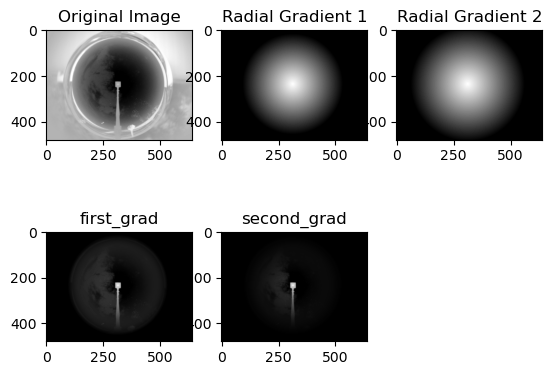

In [4]:
def create_radial_gradient(size, center, radius):

    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient):
    opacity = 0.7  # The opacity of the foreground that is blended onto the background is 70 %.
    # blended_img_float = blend_modes.soft_light(image, gradient, opacity)

    


    result = image * gradient
    # result = blended_img_float
    return result

image = img
image_size = img.shape

gradient_center = (235, 314)  # Center of the gradient
gradient_radius = 220  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)

# Multiply the image with the gradient
first_grad = multiply_with_gradient(image, gradient_1)


gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
second_grad = multiply_with_gradient(first_grad, gradient_2)


# Display the original image, gradient, and the multiplied result
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 3, 2)
plt.imshow(gradient_1, cmap='gray')
plt.title('Radial Gradient 1')

plt.subplot(2, 3, 3)
plt.imshow(gradient_2, cmap='gray')
plt.title('Radial Gradient 2')

plt.subplot(2, 3, 4)
plt.imshow(first_grad, cmap='gray')
plt.title('first_grad')

plt.subplot(2, 3, 5)
plt.imshow(second_grad, cmap='gray')
plt.title('second_grad')

plt.show()


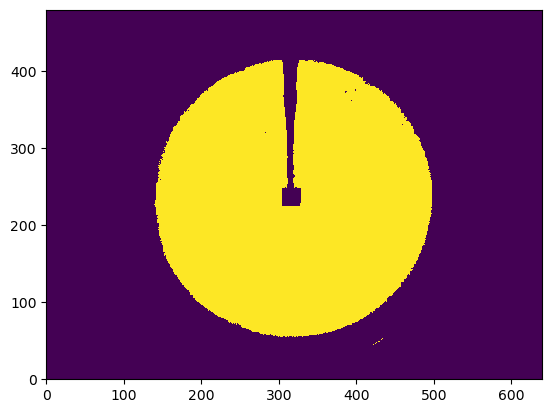

In [5]:
# mask =  (img < 30000) & (img > 10000)
mask =  (img < 30000)

plt.pcolormesh(mask)

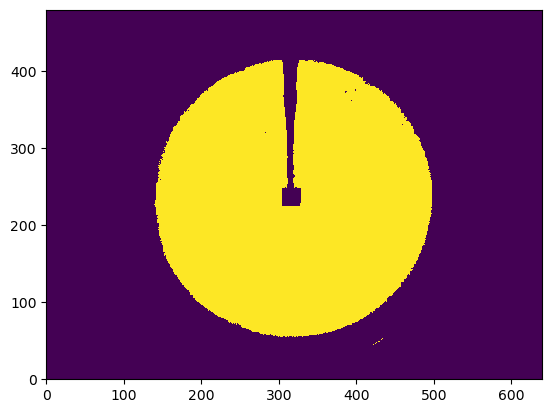

In [6]:
mask.shape
mask = clear_border(mask)
plt.pcolormesh(mask)

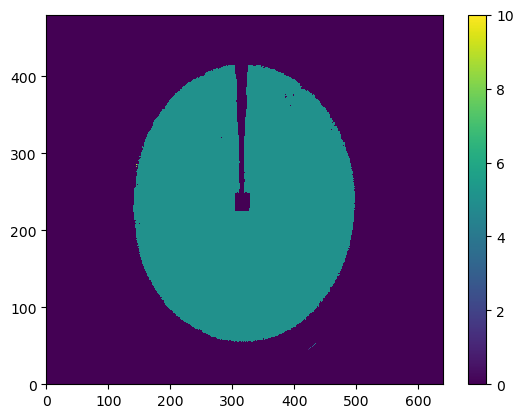

In [7]:
mask_labeled = label(mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()


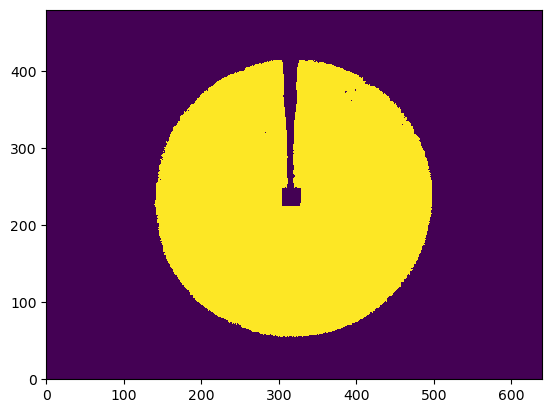

In [8]:
def remove_small(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

mask = remove_small(mask)
plt.pcolormesh(mask)


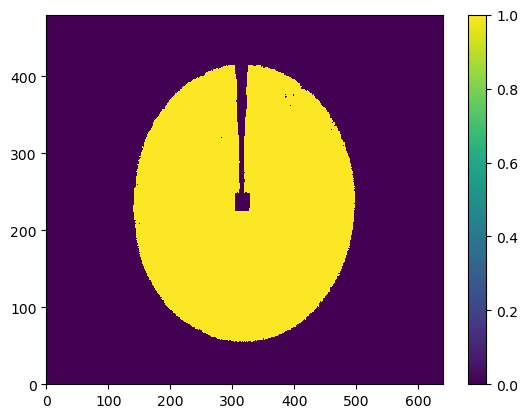

In [9]:
mask_labeled = label(mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()

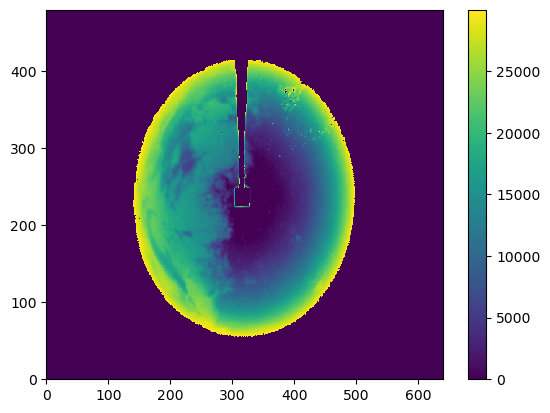

In [10]:
new_img = img * mask
plt.pcolormesh(new_img)
plt.colorbar()

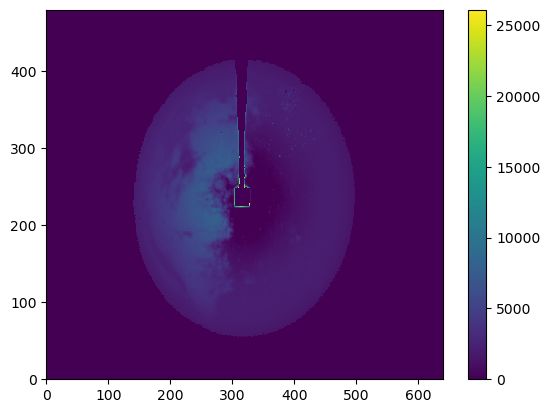

In [11]:
new_img = second_grad * mask
plt.pcolormesh(new_img)
plt.colorbar()


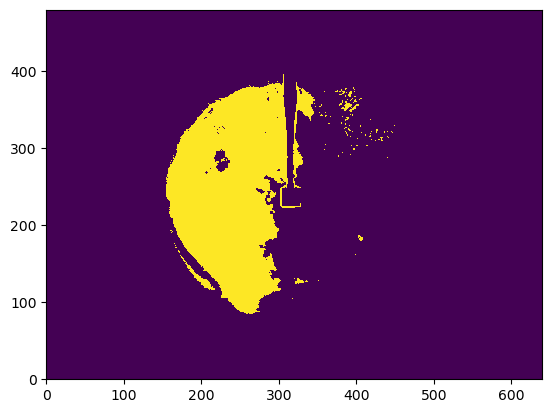

In [12]:
# mask =  (new_img < 30000) & (new_img > 500)
mask =  new_img > 2500
plt.pcolormesh(mask)

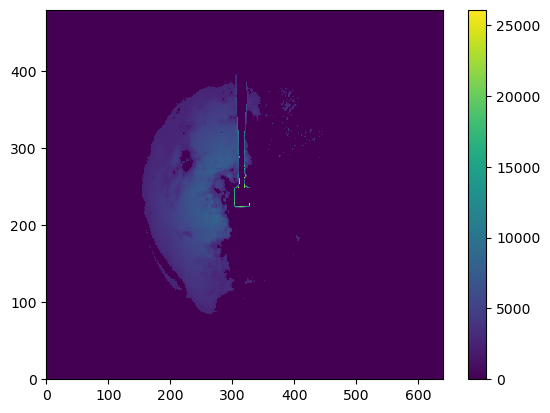

In [13]:
area_image = second_grad * mask
plt.pcolormesh(area_image)
plt.colorbar()

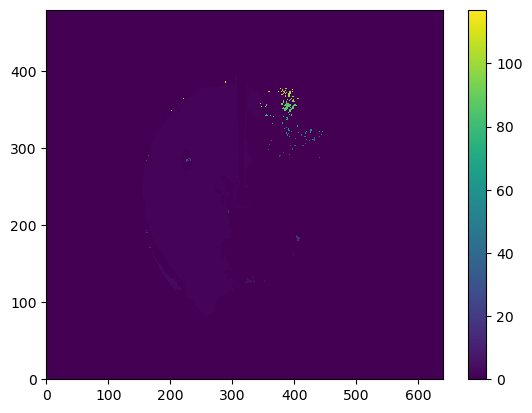

In [14]:
mask_labeled = label(mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()

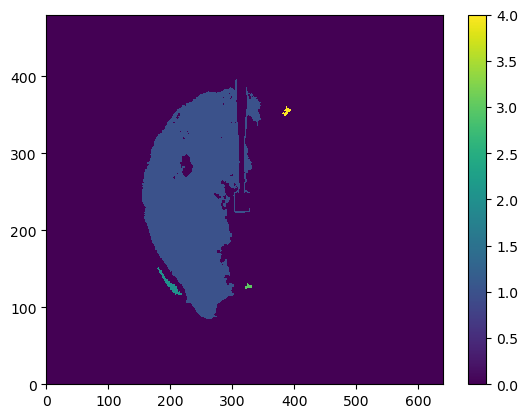

In [15]:
def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

big_mask = remove_small(mask)
mask_labeled = label(big_mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()

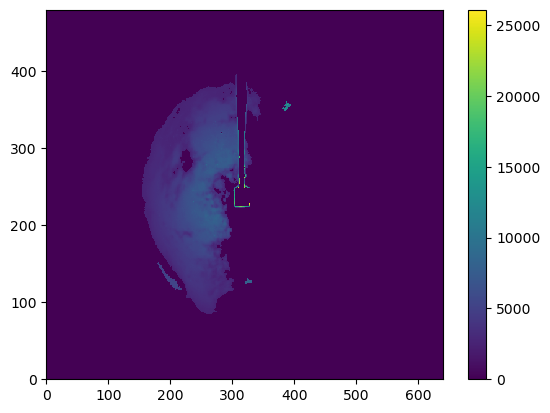

In [16]:
small_area_img = second_grad * mask_labeled
plt.pcolormesh(small_area_img)
plt.colorbar()

In [17]:
# image = small_area_img
# # apply threshold
# thresh = threshold_otsu(image)
# bw = closing(image > thresh, square(3))

# # remove artifacts connected to image border
# cleared = clear_border(bw)

# # label image regions
# label_image = label(cleared)
# # to make the background transparent, pass the value of `bg_label`,
# # and leave `bg_color` as `None` and `kind` as `overlay`
# image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)

# for region in regionprops(label_image):
#     # take regions with large enough areas
#     if region.area >= 50:
#         # draw rectangle around segmented coins
#         minr, minc, maxr, maxc = region.bbox
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                                   fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

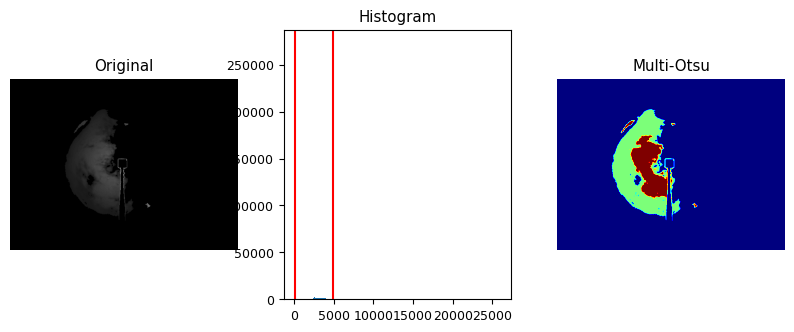

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = small_area_img

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


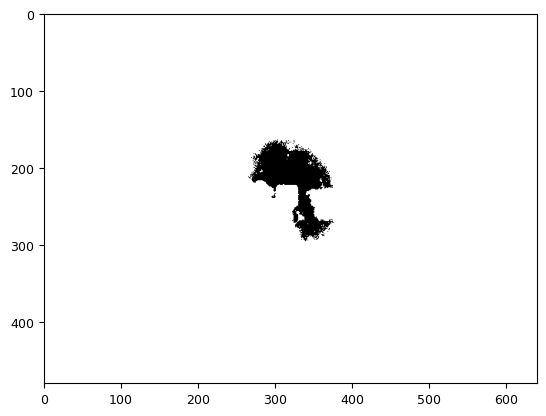

In [19]:
# 5, 6, 7, 8 y 22


# Import background image
background_img_raw = Image.open('20230807_normal/20230807163300.png')  # RGBA image
background_img = np.array(background_img_raw)  # Inputs to blend_modes need to be numpy arrays.
background_img_float = background_img.astype(float)  # Inputs to blend_modes need to be floats.
background_img_float = np.stack((background_img_float, background_img_float, background_img_float, np.ones_like(background_img_float)), axis=-1)

# Import foreground image
second_grad_4d = np.stack((second_grad, second_grad, second_grad, 1*np.ones_like(second_grad)), axis=-1)

# Blend images
opacity = 0.7  # The opacity of the foreground that is blended onto the background is 70 %.
blended_img_float = blend_modes.multiply(background_img_float, second_grad_4d, opacity)



# Convert blended image back into PIL image
blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
                                                # This behavior is difficult to change (although possible).
                                                # If you have alpha channels in your images, then you should give
                                                # OpenCV a try.

# # Display blended image
# blended_img_raw.show()
plt.imshow(blended_img_float, cmap='gray')